# Improved Traffic Sign Recognition with Hybrid CNN-Tsetlin Machine

This notebook implements an improved hybrid approach for traffic sign recognition using:
1. Adaptive Gaussian thresholding for preprocessing
2. A simplified CNN for feature extraction
3. Tsetlin Machine for classification of extracted features

## 1. Import Libraries

In [12]:
import pickle
import pandas as pd
import numpy as np
import cv2
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras for the CNN feature extractor
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Tsetlin Machine for classification
from tmu.models.classification.vanilla_classifier import TMClassifier

## 2. Helper Functions

These functions help with loading data and preprocessing images using adaptive Gaussian thresholding.

In [13]:
def load_pickle_file(file_path):
    """Load pickle files containing the datasets."""
    with open(file_path, 'rb') as file:
        data = pickle.load(file, encoding='latin1')
    return data

def load_sign_names(csv_path):
    """Load mapping of class IDs to sign names from CSV."""
    df = pd.read_csv(csv_path)
    sign_mapping = dict(zip(df['ClassId'], df['SignName']))
    return sign_mapping

def preprocess_images_with_adaptive_thresholding(image):
    """Preprocess images using adaptive Gaussian thresholding method.
    
    This approach adapts the threshold based on local image regions,
    which can better handle varying lighting conditions across the image.
    """
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Apply adaptive Gaussian thresholding
    # Parameters: block size = 11, C = 2 (constant subtracted from the mean)
    binary_image = cv2.adaptiveThreshold(
        blurred, 
        1, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 
        11, 
        2
    )
    return binary_image

def visualize_preprocessing(original_image, preprocessed_image, ax=None):
    """Visualize the original and preprocessed images side by side."""
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Plot original image
    if len(original_image.shape) == 3 and original_image.shape[2] == 3:
        ax[0].imshow(original_image)
    else:
        ax[0].imshow(original_image, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    
    # Plot preprocessed image
    ax[1].imshow(preprocessed_image, cmap='gray')
    ax[1].set_title('Preprocessed Image')
    ax[1].axis('off')

    return ax

## 3. Load and Prepare Data

Load the traffic sign data from pickle files and the sign name mapping.

In [14]:
# Update these paths to match your local file locations
sign_mapping = load_sign_names('C:/Users/ahpuh/Desktop/Improved_Tsetlin_Machine/signname.csv')
train_data = load_pickle_file('C:/Users/ahpuh/Desktop/Improved_Tsetlin_Machine/train.p')
valid_data = load_pickle_file('C:/Users/ahpuh/Desktop/Improved_Tsetlin_Machine/valid.p')
test_data = load_pickle_file('C:/Users/ahpuh/Desktop/Improved_Tsetlin_Machine/test.p')

X_train, y_train = train_data['features'], train_data['labels']
X_valid, y_valid = valid_data['features'], valid_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

# Determine the number of classes for the classifier
num_classes = len(np.unique(y_train))

# Display data summary
print(f"Training set: {X_train.shape} images, {y_train.shape} labels")
print(f"Validation set: {X_valid.shape} images, {y_valid.shape} labels")
print(f"Test set: {X_test.shape} images, {y_test.shape} labels")
print(f"Number of unique classes: {num_classes}")

Training set: (34799, 32, 32, 3) images, (34799,) labels
Validation set: (4410, 32, 32, 3) images, (4410,) labels
Test set: (12630, 32, 32, 3) images, (12630,) labels
Number of unique classes: 43


## 4. Preprocess Data using Adaptive Gaussian Thresholding

Apply adaptive Gaussian thresholding to preprocess the images.

Preprocessing training data...
Preprocessing validation data...
Preprocessing test data...
Processed data shapes: (34799, 32, 32), (4410, 32, 32), (12630, 32, 32)


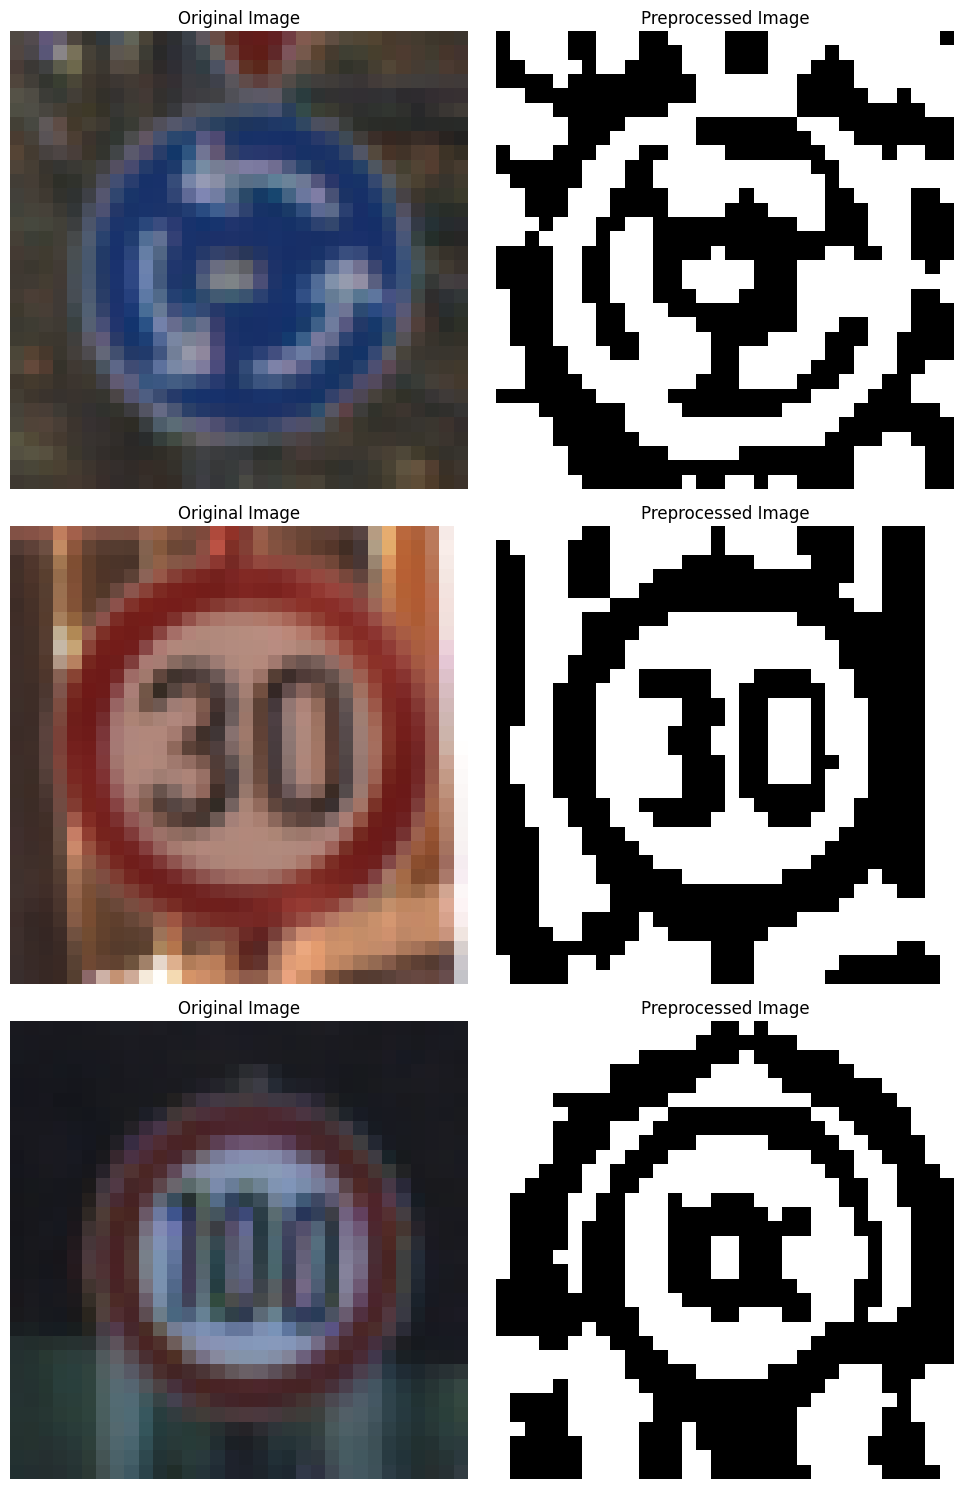

In [15]:
# Preprocess all datasets
print("Preprocessing training data...")
X_train_binary = np.array([preprocess_images_with_adaptive_thresholding(img) for img in X_train])

print("Preprocessing validation data...")
X_valid_binary = np.array([preprocess_images_with_adaptive_thresholding(img) for img in X_valid])

print("Preprocessing test data...")
X_test_binary = np.array([preprocess_images_with_adaptive_thresholding(img) for img in X_test])

# Display preprocessed shapes
print(f"Processed data shapes: {X_train_binary.shape}, {X_valid_binary.shape}, {X_test_binary.shape}")

# Visualize a few examples of the preprocessing
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
for i in range(3):
    idx = np.random.randint(0, len(X_train))
    visualize_preprocessing(X_train[idx], X_train_binary[idx], axes[i])

plt.tight_layout()
plt.show()

## 5. Simplified CNN Architecture for Feature Extraction

Design a simplified CNN architecture for feature extraction.

In [16]:
def build_feature_extractor():
    """Build a simplified CNN feature extractor with fewer parameters"""
    inputs = Input(shape=(32, 32, 1))
    
    # First convolutional block - fewer filters (16 instead of 32)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Second convolutional block - fewer filters (24 instead of 64)
    x = Conv2D(24, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Output: 8x8x24 = 1536 features
    model = Model(inputs=inputs, outputs=x, name="cnn_feature_extractor")
    return model

# Create and display the architecture
feature_extractor = build_feature_extractor()
feature_extractor.summary()

# Prepare data for the CNN (add channel dimension)
X_train_cnn = X_train_binary.reshape(-1, 32, 32, 1)
X_valid_cnn = X_valid_binary.reshape(-1, 32, 32, 1)
X_test_cnn = X_test_binary.reshape(-1, 32, 32, 1)

Model: "cnn_feature_extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 24)     │         3,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 24)     │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 24)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,800 (14.84 KB)

 Trainable params: 3,720 (14.53 KB)

 Non-trainable params: 80 (320.00 B)

## 6. Pre-training the CNN Feature Extractor

Pre-train the CNN feature extractor on the classification task to learn useful features.

Pre-training the CNN feature extractor...
Epoch 1/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.4113 - loss: 2.2560 - val_accuracy: 0.7728 - val_loss: 0.7998
Epoch 2/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8289 - loss: 0.5406 - val_accuracy: 0.8349 - val_loss: 0.5375
Epoch 3/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.8974 - loss: 0.3170 - val_accuracy: 0.8687 - val_loss: 0.4722
Epoch 4/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9240 - loss: 0.2307 - val_accuracy: 0.8637 - val_loss: 0.5046
Epoch 5/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9404 - loss: 0.1777 - val_accuracy: 0.8651 - val_loss: 0.5203
Epoch 6/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9478 - loss: 0.1527 - val_accuracy: 0.8646 - val_loss: 0.5709
Epoch 7/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9576 - loss: 0.1266 - val_accuracy: 0.8710 - val_loss: 0.5760
Epoch 8/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - 

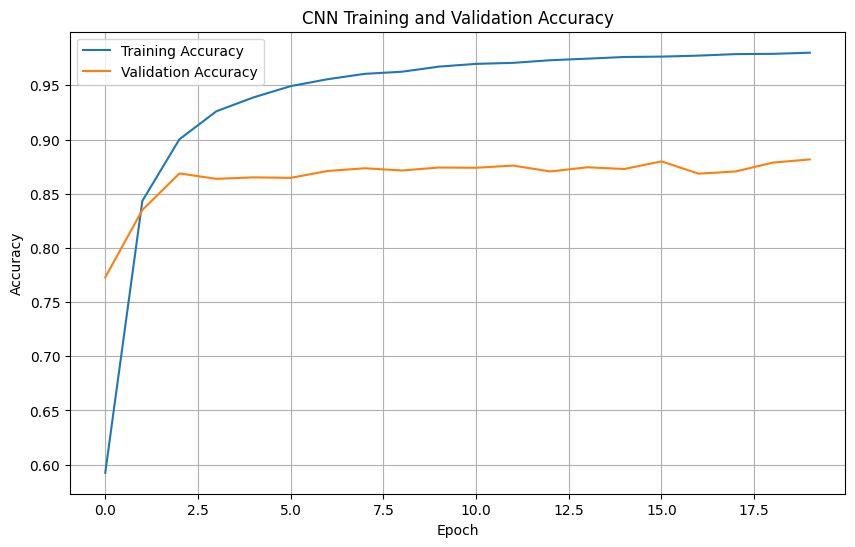

In [17]:
# Create a full CNN model for pre-training (feature extractor + classifier head)
def build_cnn_classifier(feature_extractor):
    """Build a complete CNN classifier using the feature extractor"""
    model = Sequential([
        feature_extractor,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Create the complete CNN classifier
cnn_classifier = build_cnn_classifier(feature_extractor)
cnn_classifier.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

# Train the CNN
print("Pre-training the CNN feature extractor...")
history = cnn_classifier.fit(
    X_train_cnn, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_valid_cnn, y_valid),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate CNN performance
cnn_valid_acc = cnn_classifier.evaluate(X_valid_cnn, y_valid)[1] * 100
print(f"CNN Validation Accuracy: {cnn_valid_acc:.2f}%")

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## 7. Extract Features using the Pre-trained CNN

Extract features from all datasets using the pre-trained feature extractor.

Extracting features from training data...
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Extracting features from validation data...
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Extracting features from test data...
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Feature shapes: (34799, 1536), (4410, 1536), (12630, 1536)


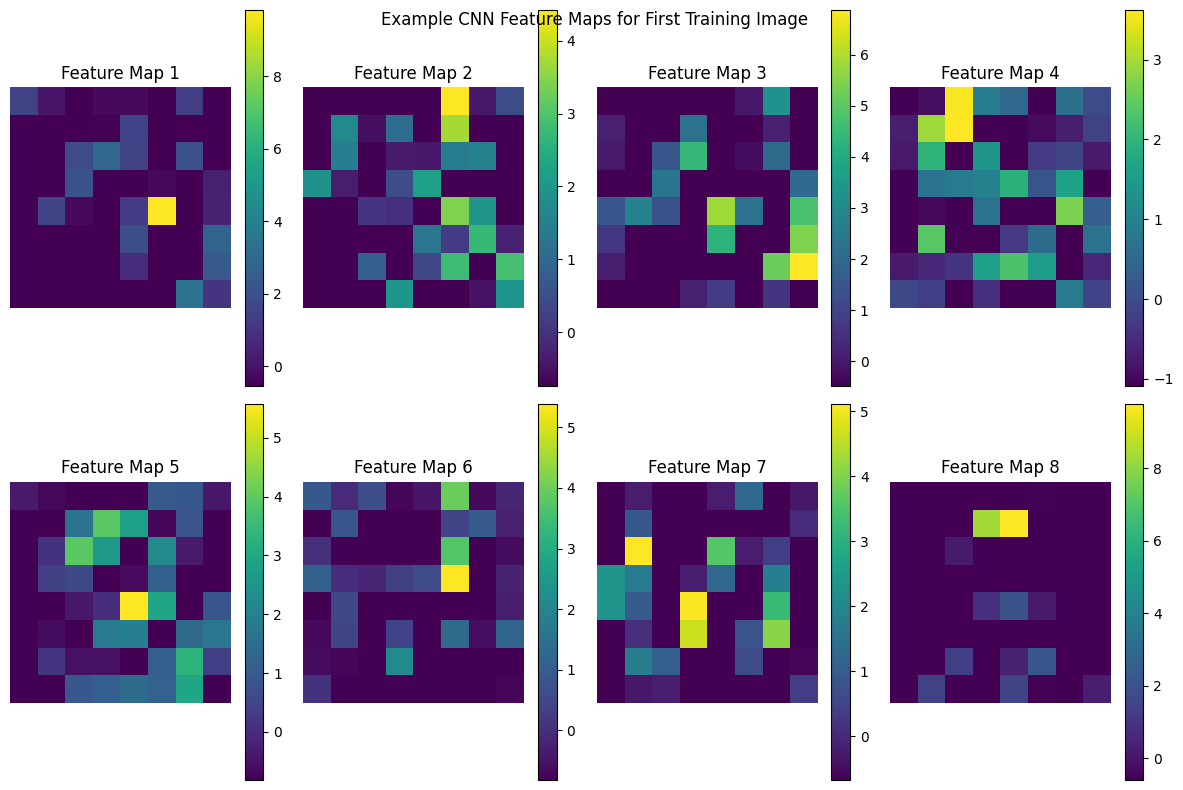

In [18]:
# Extract features from all datasets
print("Extracting features from training data...")
X_train_features = feature_extractor.predict(X_train_cnn)
print("Extracting features from validation data...")
X_valid_features = feature_extractor.predict(X_valid_cnn)
print("Extracting features from test data...")
X_test_features = feature_extractor.predict(X_test_cnn)

# Flatten and binarize the features for the Tsetlin Machine
# We threshold at 0 since ReLU activation produces positive values
threshold = 0.1

X_train_features_flat = (X_train_features.reshape(X_train_features.shape[0], -1) > threshold).astype(np.uint32)
X_valid_features_flat = (X_valid_features.reshape(X_valid_features.shape[0], -1) > threshold).astype(np.uint32)
X_test_features_flat = (X_test_features.reshape(X_test_features.shape[0], -1) > threshold).astype(np.uint32)

print(f"Feature shapes: {X_train_features_flat.shape}, {X_valid_features_flat.shape}, {X_test_features_flat.shape}")

# Visualize some extracted features
plt.figure(figsize=(12, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(X_train_features[0, :, :, i], cmap='viridis')
    plt.title(f'Feature Map {i+1}')
    plt.colorbar()
    plt.axis('off')
plt.tight_layout()
plt.suptitle('Example CNN Feature Maps for First Training Image')
plt.show()

## 8. Configure and Train the Tsetlin Machine

Configure and train the Tsetlin Machine on the extracted CNN features.

In [19]:
# Convert labels to uint32 for Tsetlin Machine compatibility
y_train_tm = y_train.astype(np.uint32)
y_valid_tm = y_valid.astype(np.uint32)
y_test_tm = y_test.astype(np.uint32)

# Configure Tsetlin Machine with optimized parameters
# Use more clauses since we're working with CNN-extracted features
num_features = X_train_features_flat.shape[1]
num_clauses = 200  # More clauses for better representational capacity

# Improved T and s parameter calculation for better accuracy
# T controls threshold for including literals (higher = more conservative)
# s controls specificity (influences Type I vs Type II feedback balance)
T = max(15, int(num_clauses * 0.15))  # Scale T with clause count, minimum of 15
s = 3.0  # Lower s value (compared to default) for more aggressive learning

# Alternative configurations to try (uncomment to experiment)
# Configuration 1: More conservative
# T = max(20, int(num_clauses * 0.2))
# s = 2.5

# Configuration 2: More balanced
# T = max(10, int(num_clauses * 0.1))
# s = 3.9

# Create the Tsetlin Machine classifier
hybrid_tm = TMClassifier(
    number_of_clauses=num_clauses,
    T=T,
    s=s,
    clause_drop_p=0.05,  # Small dropout for regularization
    weighted_clauses=True  # Use weighted clauses for better performance
)

print(f"Tsetlin Machine configured with:")
print(f"- {hybrid_tm.number_of_clauses} clauses")
print(f"- T={hybrid_tm.T}, s={hybrid_tm.s}, drop_p={hybrid_tm.clause_drop_p}")
print(f"- Working with {num_features} features")

# Train the Tsetlin Machine with early stopping
print("\nTraining Hybrid CNN-Tsetlin Machine...")
best_val_acc = 0.0
patience = 20
patience_counter = 0
best_epoch = 0

# Track metrics for plotting
hybrid_train_accuracies = []
hybrid_valid_accuracies = []

for epoch in range(100):  # Fewer epochs needed when using pre-extracted features
    # Train for multiple epochs per iteration
    hybrid_tm.fit(X_train_features_flat, y_train_tm, epochs=2)
    
    train_pred = hybrid_tm.predict(X_train_features_flat)
    valid_pred = hybrid_tm.predict(X_valid_features_flat)
    
    train_acc = accuracy_score(y_train_tm, train_pred) * 100
    valid_acc = accuracy_score(y_valid_tm, valid_pred) * 100
    
    hybrid_train_accuracies.append(train_acc)
    hybrid_valid_accuracies.append(valid_acc)
    
    print(f"Epoch {epoch+1}/100 - Train Accuracy: {train_acc:.2f}% | Validation Accuracy: {valid_acc:.2f}%")
    
    if valid_acc > best_val_acc:
        best_val_acc = valid_acc
        best_epoch = epoch
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping after {epoch+1} epochs.")
            break

print(f"\nBest validation accuracy: {best_val_acc:.2f}% at epoch {best_epoch+1}")

Tsetlin Machine configured with:
- 200 clauses
- T=30, s=3.0, drop_p=0.05
- Working with 1536 features

Training Hybrid CNN-Tsetlin Machine...
Epoch 1/100 - Train Accuracy: 81.91% | Validation Accuracy: 72.09%
Epoch 2/100 - Train Accuracy: 85.99% | Validation Accuracy: 74.72%
Epoch 3/100 - Train Accuracy: 88.28% | Validation Accuracy: 75.60%
Epoch 4/100 - Train Accuracy: 90.18% | Validation Accuracy: 78.12%
Epoch 5/100 - Train Accuracy: 90.02% | Validation Accuracy: 77.57%
Epoch 6/100 - Train Accuracy: 92.16% | Validation Accuracy: 79.48%
Epoch 7/100 - Train Accuracy: 92.75% | Validation Accuracy: 80.14%
Epoch 8/100 - Train Accuracy: 93.14% | Validation Accuracy: 80.61%
Epoch 9/100 - Train Accuracy: 93.24% | Validation Accuracy: 81.32%
Epoch 10/100 - Train Accuracy: 93.49% | Validation Accuracy: 80.93%
Epoch 11/100 - Train Accuracy: 94.01% | Validation Accuracy: 81.63%
Epoch 12/100 - Train Accuracy: 94.53% | Validation Accuracy: 82.02%
Epoch 13/100 - Train Accuracy: 95.13% | Validation

## 9. Plotting Training Progress

Plot the training and validation accuracy of the hybrid model.

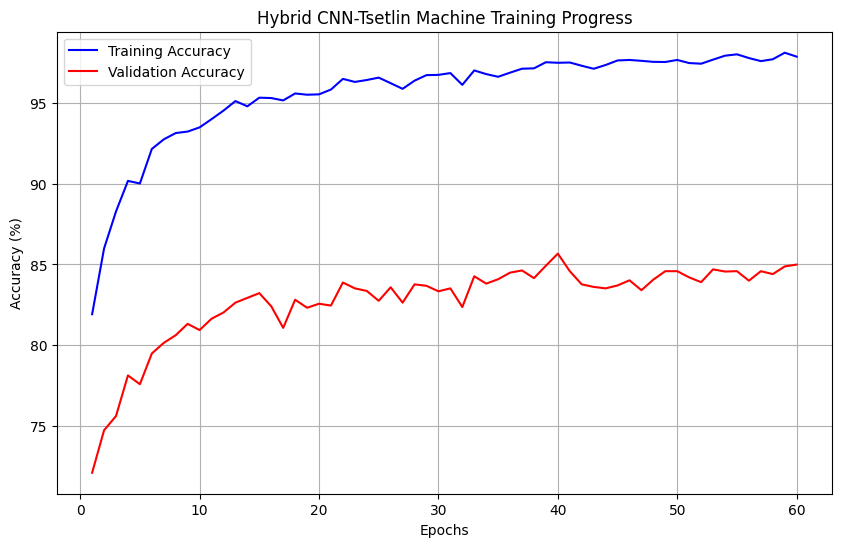

In [20]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(10, 6))
epochs = range(1, len(hybrid_train_accuracies) + 1)
plt.plot(epochs, hybrid_train_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs, hybrid_valid_accuracies, 'r-', label='Validation Accuracy')
plt.title('Hybrid CNN-Tsetlin Machine Training Progress')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

## 10. Evaluate on Test Set

Evaluate the hybrid model on the test set and compare with other models.

Hybrid CNN-Tsetlin Machine Test Accuracy: 85.32%
Pure CNN Test Accuracy: 89.77%


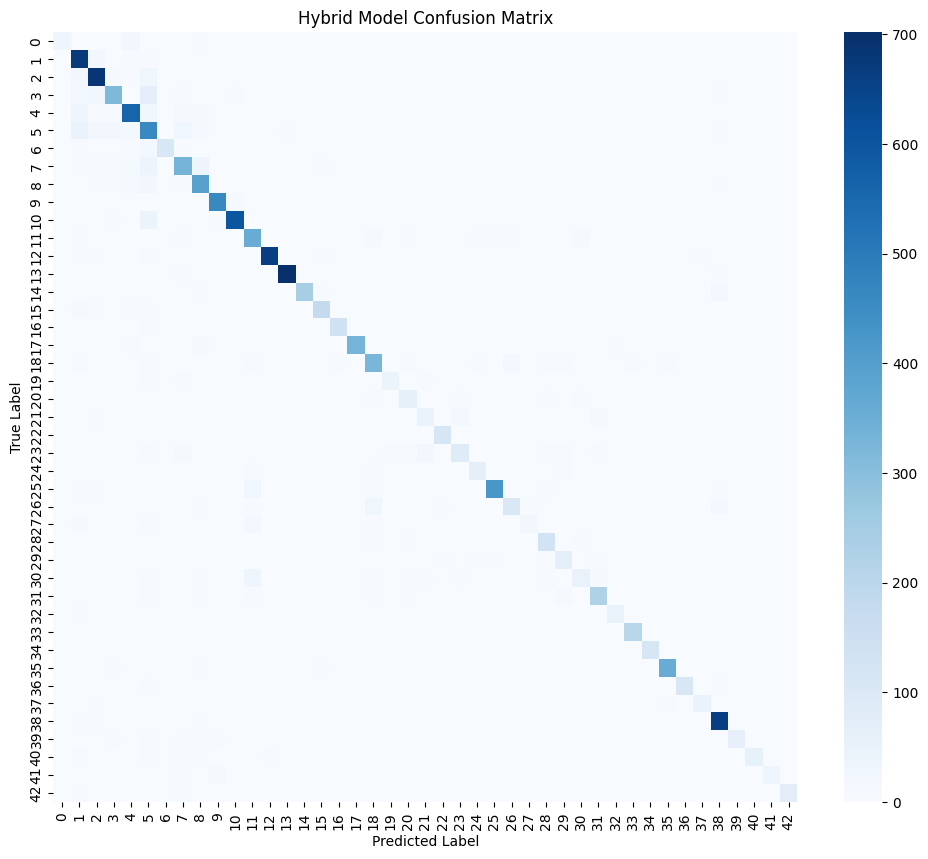

In [21]:
# Evaluate on Test Set
hybrid_test_pred = hybrid_tm.predict(X_test_features_flat)
hybrid_test_acc = accuracy_score(y_test_tm, hybrid_test_pred) * 100
print(f"Hybrid CNN-Tsetlin Machine Test Accuracy: {hybrid_test_acc:.2f}%")

# For comparison, also evaluate the full CNN model
cnn_test_acc = cnn_classifier.evaluate(X_test_cnn, y_test, verbose=0)[1] * 100
print(f"Pure CNN Test Accuracy: {cnn_test_acc:.2f}%")

# Create confusion matrix for the hybrid model
hybrid_cm = confusion_matrix(y_test_tm, hybrid_test_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(hybrid_cm, annot=False, fmt='d', cmap='Blues')
plt.title('Hybrid Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 11. Visualize Test Predictions

Visualize random test samples with their predictions.

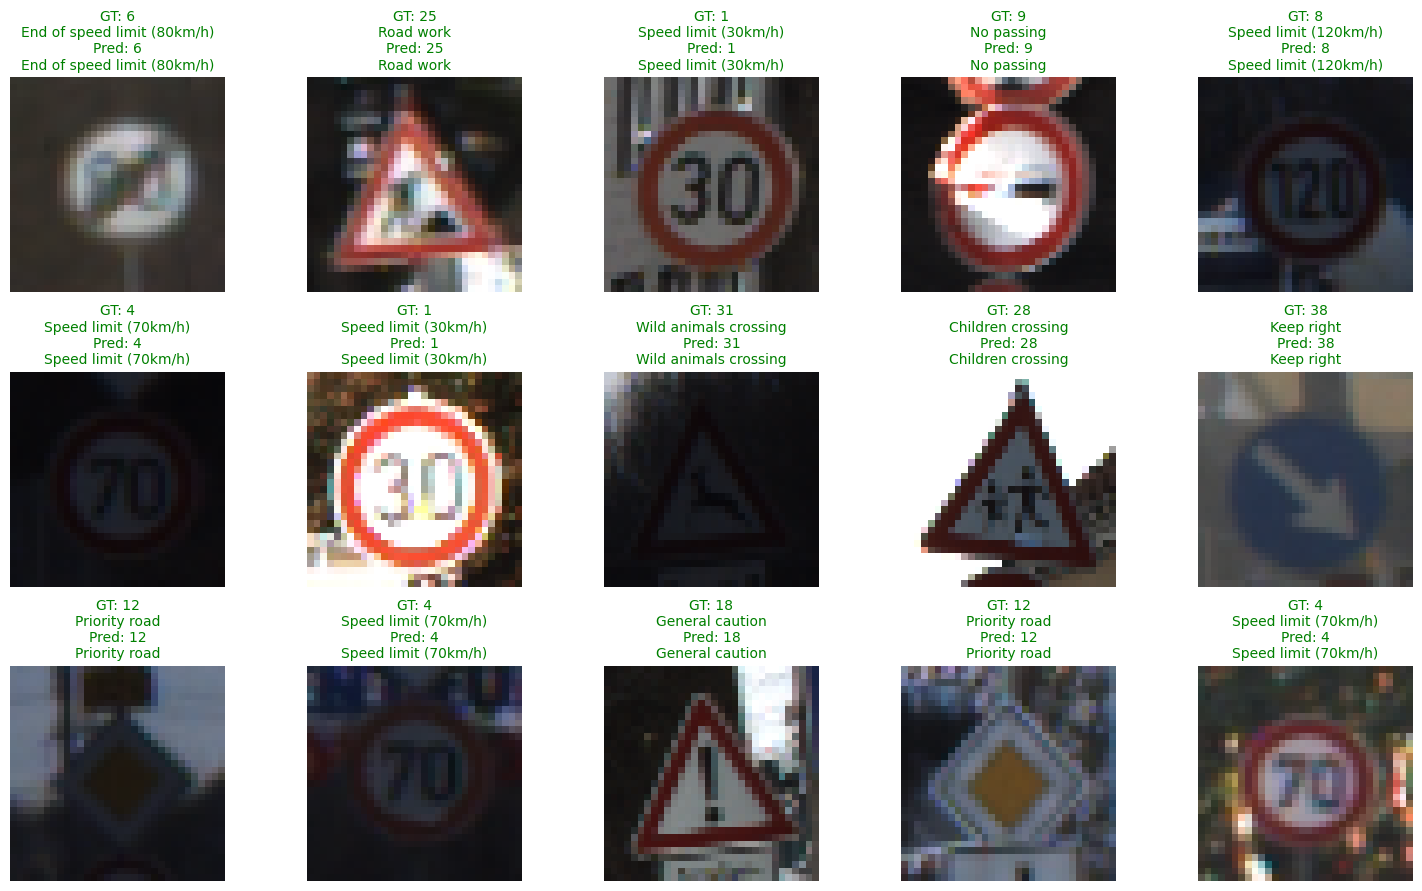

In [22]:
# Visualize Random Test Samples with Predictions
num_samples_to_show = 15
indices = np.random.choice(len(X_test), size=num_samples_to_show, replace=False)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 9))
axes = axes.flatten()

for ax, idx in zip(axes, indices):
    img = X_test[idx]
    true_label = y_test[idx]
    pred_label = hybrid_test_pred[idx]
    true_sign_name = sign_mapping.get(true_label, 'Unknown')
    pred_sign_name = sign_mapping.get(pred_label, 'Unknown')
    
    if len(img.shape) == 2:
        ax.imshow(img, cmap='gray')
    else:
        ax.imshow(img)
        
    color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f"GT: {true_label}\n{true_sign_name}\nPred: {pred_label}\n{pred_sign_name}", 
                 fontsize=10,
                 color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 12. Class-wise Accuracy Analysis

Analyze prediction accuracy by class to identify strengths and weaknesses.

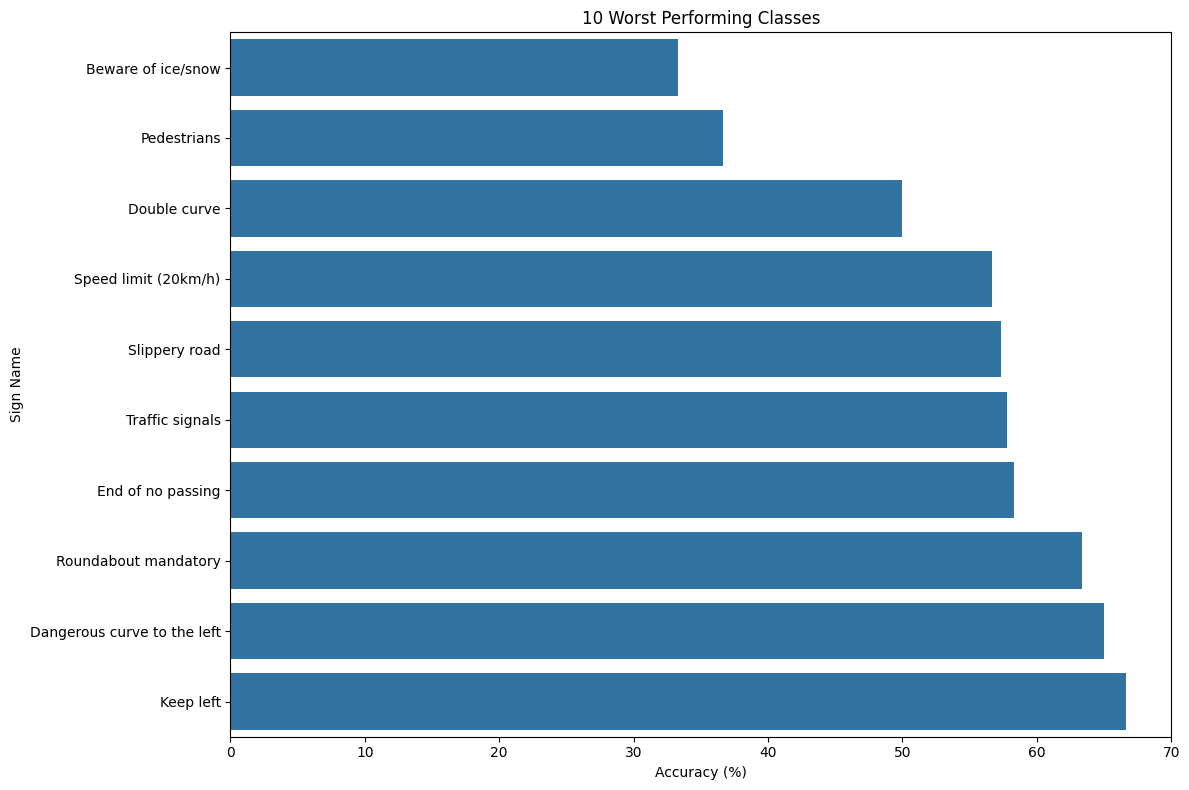

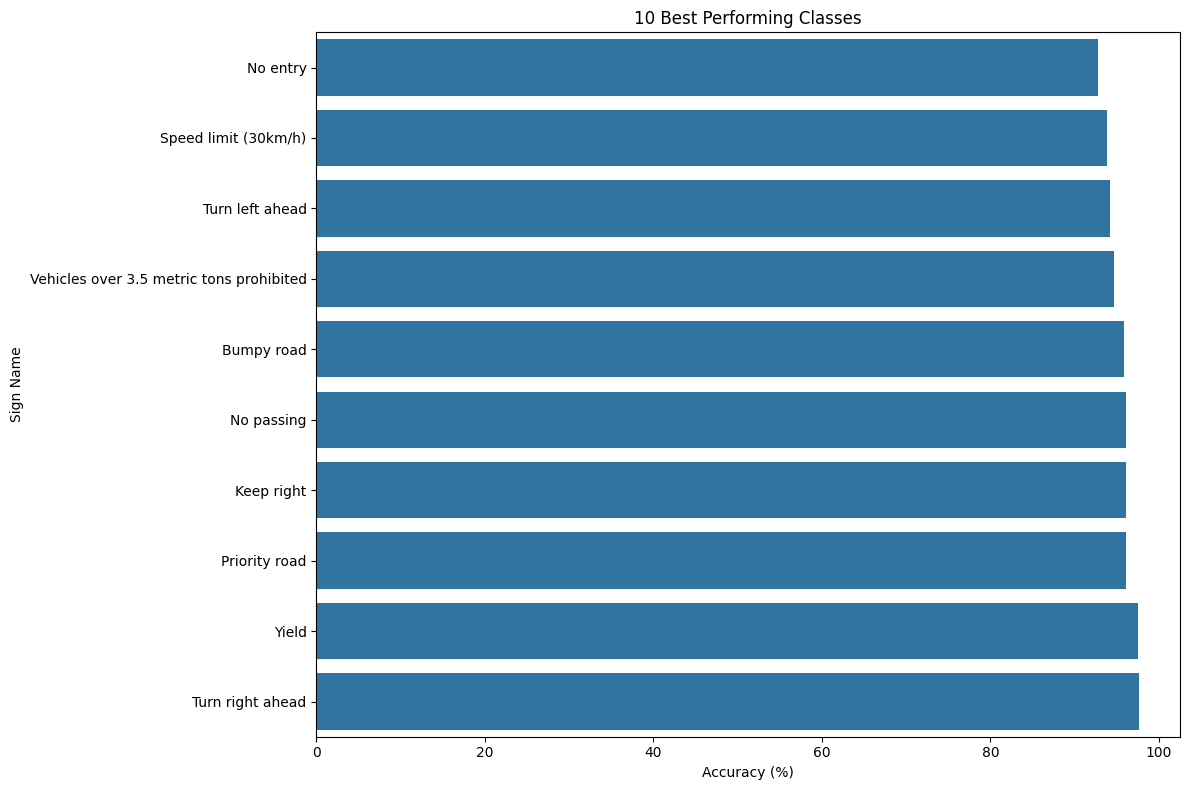

,Class ID,Sign Name,Accuracy (%),Sample Count
33,33,Turn right ahead,97.619048,210
13,13,Yield,97.500000,720
38,38,Keep right,96.086957,690
12,12,Priority road,96.086957,690
9,9,No passing,96.041667,480
22,22,Bumpy road,95.833333,120
16,16,Vehicles over 3.5 metric tons prohibited,94.666667,150
34,34,Turn left ahead,94.166667,120
1,1,Speed limit (30km/h),93.888889,720
17,17,No entry,92.777778,360


In [23]:
# Calculate per-class accuracy
class_accuracy = hybrid_cm.diagonal() / hybrid_cm.sum(axis=1) * 100

# Create a DataFrame for better visualization
class_df = pd.DataFrame({
    'Class ID': list(range(num_classes)),
    'Sign Name': [sign_mapping.get(i, 'Unknown') for i in range(num_classes)],
    'Accuracy (%)': class_accuracy,
    'Sample Count': hybrid_cm.sum(axis=1)
})

# Sort by accuracy
class_df_sorted = class_df.sort_values('Accuracy (%)')

# Plot the 10 worst-performing classes
plt.figure(figsize=(12, 8))
worst_classes = class_df_sorted.head(10)
sns.barplot(x='Accuracy (%)', y='Sign Name', data=worst_classes)
plt.title('10 Worst Performing Classes')
plt.tight_layout()
plt.show()

# Plot the 10 best-performing classes
plt.figure(figsize=(12, 8))
best_classes = class_df_sorted.tail(10)
sns.barplot(x='Accuracy (%)', y='Sign Name', data=best_classes)
plt.title('10 Best Performing Classes')
plt.tight_layout()
plt.show()

# Show the full class-wise accuracy table
class_df.sort_values('Accuracy (%)', ascending=False)

## 13. Conclusion

The hybrid CNN-Tsetlin Machine approach combines the feature extraction capabilities of CNNs with the interpretability and efficiency of Tsetlin Machines.

Key advantages of this approach:
1. Maintains the adaptive Gaussian thresholding preprocessing
2. Uses a simplified CNN architecture for efficient feature extraction
3. Leverages Tsetlin Machine's strengths for the final classification
4. Potentially achieves higher accuracy than either approach alone